##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Training NN model(s) on theoretical data generated via the simple physical model

In [58]:
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd
import numpy as np 

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb

from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm
import io

from random import randint
from sklearn.utils import shuffle


print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def azimuth(x, y):
    """
    Calculate the azimuthal angle.
    Input parameters
    ----------
    x, y: Cartesian coordinates of contour of the drop [mm]
    Returns
    -------
    Azimuthal angle in [rad]
    """
    a=np.arctan2(x, y)
    return a

def cart2pol(x, y):
  ''' Function that converts 2-dimentional 
  cartesian coordinates to polar coordinates'''
  rho = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  return(theta, rho)

def pol2cart(rho, phi):
    ''' Function that converts 2-dimentional 
  polar coordinates to cartesian coordinates'''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def pol2cart_theta(rho, theta):
   ''' Function that converts 2-dimentional 
    polar coordinates to cartesian coordinates'''
   x = rho * np.sin(theta)
   y = rho * np.cos(theta)
   return(x, y)

def log_interp1d(xx, yy, kind='linear'):            #Used for the ST calculation
  '''
  Function that is used for the interpolation in the logarithmic scale,
  among the surface tension measurements from the pendant drop method.'''
  logx = np.log10(xx)
  logy = np.log10(yy)
  lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
  log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
  return log_interp

#Min-Max transformation

def MinMaxTransformTrain(dataset_train, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(dataset_train)):
    max_rho.append(max(dataset_train.iloc[i, 0:points].values))
    min_rho.append(min(dataset_train.iloc[i, 0:points].values))
    # max_theta.append(max(dataset_train.iloc[i, points:2*points].values))
    # min_theta.append(min(dataset_train.iloc[i, points:2*points].values))


  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))
  
  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_train)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=(NewValue)
    else:
        NewValue = (dataset_train.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = abs(OldMax - OldMin)
  # for i in range(len(dataset_train)):
  #   if (OldRange == 0):
  #       NewValue = NewMin
  #       NewValues_theta[i]=(NewValue)
  #   else:
  #       NewValue = (dataset_train.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue



  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_theta, df_rho], axis=1)

  return df_rho



def MinMaxTransformTest(dataset_test, dataset_train, points):

  max_rho=[]
  min_rho=[]
  # min_theta=[]
  # max_theta=[]
  for i in range(len(dataset_train)):
    max_rho.append(max(dataset_train.iloc[i, 0:points].values))
    min_rho.append(min(dataset_train.iloc[i, 0:points].values))
    # max_theta.append(max(dataset_train.iloc[i, points:2*points].values))
    # min_theta.append(min(dataset_train.iloc[i, points:2*points].values))


  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_test)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (dataset_test.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # # Change the range of theta from 0 to 1

  # OldMax= max(max_theta)
  # OldMin=min(min_theta)

  # NewValues_theta={}

  # OldRange = abs(OldMax - OldMin)
  # for i in range(len(dataset_test)):
  #   if (OldRange == 0):
  #       NewValue = NewMin
  #       NewValues.append(NewValue)
  #   else:
  #       NewValue = (dataset_test.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
  #       NewValues_theta[i]=NewValue



  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  # df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  # new_df=pd.concat([df_theta, df_rho], axis=1)

  return df_rho


def MinMaxTransform_rho(rho, points):

  max_rho=[]
  min_rho=[]

  for i in range(len(rho)):
    max_rho.append(max(rho.iloc[i].values))
    min_rho.append(min(rho.iloc[i].values))


  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (rho.iloc[i] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T

  return df_rho

def min_max_norm(x):
  return (x-stats['min'])/abs((stats['max']-stats['min']))




def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


2.9.2
Num GPUs Available:  0


Check the connection to google's **GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Check the connection to google's **TPU**

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.83.205.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.83.205.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### Generate data based on experimental data

Run the next code box only if google drive is not mounted to colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Isotherms

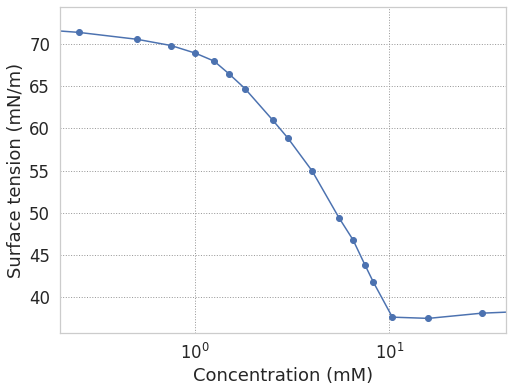

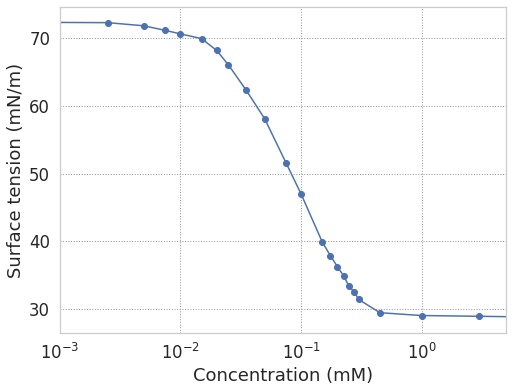

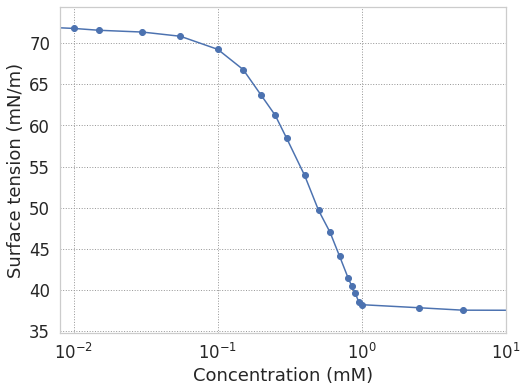

In [15]:

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/Experimental/Figures/'
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})



### SDS ###
SDS_ST=([72.6, 72.4, 72.37031515, 72.24348955, 72.02090637, 71.57361206, 71.35741272, 70.538579, 69.8, 68.9, 67.9557165, 66.4, 64.7, 61, 58.84580885, 54.95967152, 49.41774496, 46.8, 43.8, 41.76619181, 37.64478546, 37.5, 38.11484029, 38.6176825])
SDS_conc=([0.001, 0.01054, 0.02108, 0.04273, 0.08828, 0.18619, 0.25000, 0.50000, 0.75000, 1.00000, 1.25000, 1.5000, 1.80318, 2.50000, 3.00000, 4.00000, 5.50000, 6.50000, 7.50000, 8.28768, 10.36830, 15.90956, 29.92580, 100.0400])

plt.figure(figsize=(8,6))
plt.semilogx(SDS_conc, SDS_ST, '-o')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.2, 40)
if savefig==True:
  plt.savefig(path+'isotherm_SDS_svg', dpi=300, format='svg')
  plt.savefig(path+'isotherm_SDS_png', dpi=300, format='png')


### TritonX-100 ###
TX100_ST=([72.4, 72.28270549, 71.81675856, 71.14271576, 70.62624609, 69.9219077, 68.17298131, 66.04079481, 62.34195185, 58.07230446, 51.5847704, 46.98355058, 39.86331894, 37.86415677, 36.23936249, 34.89976506, 33.33080616, 32.53255599, 31.40032558, 29.43824008, 29.01899104, 28.90774169, 28.77915479, 28.6])
TX100_conc=([0.00010, 0.00250, 0.00500, 0.00750, 0.01000, 0.01500, 0.02000, 0.0250, 0.03500, 0.05000, 0.07500, 0.10000, 0.15000, 0.17500, 0.20000, 0.22500, 0.25000, 0.27500, 0.30000, 0.45000, 1.00000, 3.00000, 10.00000, 100.00000])

plt.figure(figsize=(8,6))
plt.semilogx(TX100_conc, TX100_ST, '-o')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.001, 5)
if savefig==True:
  plt.savefig(path+'isotherm_TX100_svg', dpi=300, format='svg')
  plt.savefig(path+'isotherm_TX100_png', dpi=300, format='png')

### CTAB ###
CTAB_ST=([72.6, 72.24748707, 72.08796206, 72.04127631, 71.80186884, 71.57607958, 71.35932355, 70.8470728, 69.25175673, 66.79325079, 63.6671448, 61.24273577, 58.4542436, 53.92384763, 49.66474623, 47.01343426, 44.0721636, 41.48171948, 40.43714693, 39.55888282, 38.52510061, 38.1868, 37.81413874, 37.52017359, 37.50603202, 36.52246603]) 
CTAB_conc=([0.00001, 0.00100, 0.00200, 0.00500, 0.01000, 0.01500, 0.03000, 0.05500, 0.10000, 0.15000, 0.20000, 0.25000, 0.30000, 0.40000, 0.50000, 0.60000, 0.70000, 0.80000, 0.85000, 0.90000, 0.95000, 1.00000, 2.50000, 5.00000, 13.15224, 96.30951]) 

plt.figure(figsize=(8,6))
plt.semilogx(CTAB_conc, CTAB_ST, '-o')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.008, 10)
if savefig==True:
  plt.savefig(path+'isotherm_CTAB_svg', dpi=300, format='svg')
  plt.savefig(path+'isotherm_CTAB_png', dpi=300, format='png')

#### Raw datasets

In [5]:
# #From the drive folder that is mounted to collab go to the file that you are interested in, 
# #right click and copy the path of the file. Paste it in csvfilename:
path_files=str('/content/drive/My Drive/DropLev/for_draft/Experimental/Raw_data/')
os.chdir(path_files)

# fileSDS1=pd.read_csv(str('SDS/SDS_conci_0.01054_all_175.csv'), sep="\t", header=None)
# fileSDS2=pd.read_csv(str('SDS/SDS_conci_0.02108_all_175.csv'), sep='\t', header=None)
# fileSDS3=pd.read_csv(str('SDS/SDS_conci_0.04273_all_175.csv'), sep='\t', header=None)
# fileSDS4=pd.read_csv(str('SDS/SDS_conci_0.08828_all_175.csv'), sep="\t", header=None)
# fileSDS5=pd.read_csv(str('SDS/SDS_conci_0.25000_all_175.csv'), sep="\t", header=None)
# fileSDS6=pd.read_csv(str('SDS/SDS_conci_0.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS7=pd.read_csv(str('SDS/SDS_conci_0.75000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS8=pd.read_csv(str('SDS/SDS_conci_1.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS9=pd.read_csv(str('SDS/SDS_conci_1.25000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS10=pd.read_csv(str('SDS/SDS_conci_1.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS11=pd.read_csv(str('SDS/SDS_conci_2.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS12=pd.read_csv(str('SDS/SDS_conci_2.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS13=pd.read_csv(str('SDS/SDS_conci_3.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS14=pd.read_csv(str('SDS/SDS_conci_3.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS15=pd.read_csv(str('SDS/SDS_conci_4.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS16=pd.read_csv(str('SDS/SDS_conci_4.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS17=pd.read_csv(str('SDS/SDS_conci_5.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS18=pd.read_csv(str('SDS/SDS_conci_6.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS19=pd.read_csv(str('SDS/SDS_conci_7.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileSDS20=pd.read_csv(str('SDS/SDS_conci_8.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileSDS21=pd.read_csv(str('SDS/SDS_conci_24.75900_all_175_tilt_corr.csv'), sep="\t", header=None)

# fileTrit1=pd.read_csv(str('TritonX100/TritonX_conci_0.00250_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit2=pd.read_csv(str('TritonX100/TritonX_conci_0.00500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit3=pd.read_csv(str('TritonX100/TritonX_conci_0.00750_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit4=pd.read_csv(str('TritonX100/TritonX_conci_0.01000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit5=pd.read_csv(str('TritonX100/TritonX_conci_0.01500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit6=pd.read_csv(str('TritonX100/TritonX_conci_0.02000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit7=pd.read_csv(str('TritonX100/TritonX_conci_0.02500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit8=pd.read_csv(str('TritonX100/TritonX_conci_0.03500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit9=pd.read_csv(str('TritonX100/TritonX_conci_0.05000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit10=pd.read_csv(str('TritonX100/TritonX_conci_0.07500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit11=pd.read_csv(str('TritonX100/TritonX_conci_0.10000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit12=pd.read_csv(str('TritonX100/TritonX_conci_0.12500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit13=pd.read_csv(str('TritonX100/TritonX_conci_0.15000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit14=pd.read_csv(str('TritonX100/TritonX_conci_0.17500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit15=pd.read_csv(str('TritonX100/TritonX_conci_0.20000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit16=pd.read_csv(str('TritonX100/TritonX_conci_0.25000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit17=pd.read_csv(str('TritonX100/TritonX_conci_0.30000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit18=pd.read_csv(str('TritonX100/TritonX_conci_0.45000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileTrit19=pd.read_csv(str('TritonX100/TritonX_conci_1.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit20=pd.read_csv(str('TritonX100/TritonX_conci_3.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit21=pd.read_csv(str('TritonX100/TritonX_conci_10.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileTrit22=pd.read_csv(str('TritonX100/TritonX_conci_44.62906_all_175_tilt_corr.csv'), sep="\t", header=None)

# fileCTAB1=pd.read_csv(str('CTAB/CTAB_conci_0.00100_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB2=pd.read_csv(str('CTAB/CTAB_conci_0.00200_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB3=pd.read_csv(str('CTAB/CTAB_conci_0.00500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB4=pd.read_csv(str('CTAB/CTAB_conci_0.01000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB5=pd.read_csv(str('CTAB/CTAB_conci_0.01500_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB6=pd.read_csv(str('CTAB/CTAB_conci_0.05500_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB7=pd.read_csv(str('CTAB/CTAB_conci_0.10000_all_175_tilt_corr.csv'), sep="\t", header=None) #_original_ST, _old_ST
fileCTAB8=pd.read_csv(str('CTAB/CTAB_conci_0.15000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB9=pd.read_csv(str('CTAB/CTAB_conci_0.20000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB10=pd.read_csv(str('CTAB/CTAB_conci_0.25000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB11=pd.read_csv(str('CTAB/CTAB_conci_0.30000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB12=pd.read_csv(str('CTAB/CTAB_conci_0.40000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB13=pd.read_csv(str('CTAB/CTAB_conci_0.50000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB14=pd.read_csv(str('CTAB/CTAB_conci_0.60000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB15=pd.read_csv(str('CTAB/CTAB_conci_0.70000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB16=pd.read_csv(str('CTAB/CTAB_conci_0.80000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB17=pd.read_csv(str('CTAB/CTAB_conci_0.85000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB18=pd.read_csv(str('CTAB/CTAB_conci_0.90000_all_175_tilt_corr.csv'), sep="\t", header=None)
fileCTAB19=pd.read_csv(str('CTAB/CTAB_conci_1.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB20=pd.read_csv(str('CTAB/CTAB_conci_5.00000_all_175_tilt_corr.csv'), sep="\t", header=None)
# fileCTAB21=pd.read_csv(str('CTAB/CTAB_conci_13.15224_all_175_tilt_corr.csv'), sep="\t", header=None)



# # #csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

# # #input = pd.read_csv(csvfilename)

#### Define input

In [59]:
########## Combination ###############
input_SDS=np.vstack([fileSDS8.iloc[0:1600, :], fileSDS10.iloc[0:2500, :], fileSDS12.iloc[0:3500, :], fileSDS14.iloc[0:3500, :], fileSDS17.iloc[0:4705, :], fileSDS20.iloc[800:1200,:]])
input_SDS=np.hstack([input_SDS, np.reshape(np.repeat(0, len(input_SDS)), (len(input_SDS), 1))])


input_CTAB=np.vstack([fileCTAB7.iloc[0:1600, :], fileCTAB8.iloc[500:1633, :], fileCTAB8.iloc[3700:, :], fileCTAB9.iloc[0:1670,:], 
                 fileCTAB10.iloc[1698:, :], fileCTAB11.iloc[1677:,:], fileCTAB12.iloc[0:2000, :], fileCTAB13.iloc[1673:, :],
                  fileCTAB14.iloc[3195:4650, :], fileCTAB17.iloc[700:1500, :], fileCTAB19.iloc[1300:1500, :]])

input_CTAB=np.hstack([input_CTAB, np.reshape(np.repeat(1, len(input_CTAB)), (len(input_CTAB), 1))])


input_TX100=np.vstack([fileTrit5.iloc[0:1600, :], fileTrit7.iloc[0:1500, :], fileTrit9.iloc[0:1632,:],fileTrit9.iloc[3295:, :], fileTrit10.iloc[0:1200,:], fileTrit11.iloc[0:2000,:],
                 fileTrit12.iloc[0:2300,:], fileTrit13.iloc[1000:3000, :], fileTrit14.iloc[500:3000, :], fileTrit15.iloc[0:4600, :], fileTrit17.iloc[1000:1600, :],fileTrit18.iloc[1100:1300,:], fileTrit19.iloc[400:500,:] ])

input_TX100=np.hstack([input_TX100, np.reshape(np.repeat(2, len(input_TX100)), (len(input_TX100), 1))])


input=np.vstack([input_SDS, input_CTAB, input_TX100])

input.shape

(58369, 365)

#### Define column names

In [60]:
column_names=[]
for i in range(175):
  column_names.append('rho_%d' %i)
for i in range(175):
  column_names.append('phi_%d' %i)
column_names.append('height') #350  #525  900
column_names.append('width')  #351  #526  901
column_names.append('volume') #352  #527 902
column_names.append('R_sph')  #353  #528  903
column_names.append('centre_x') #354  #529  908
column_names.append('centre_z') #355  #530  909
column_names.append('Aspect_Ratio') #356  #531  911
column_names.append('volt') #357  #532   904
column_names.append('current') #358  #533  905
column_names.append('time') #359  #534  906
column_names.append('Power') #360  #535  907
column_names.append('centred_z') #361 

column_names.append('surfactant_conc') #362   #536 910

column_names.append('ST') #362   #537  912

column_names.append('surf_number')



In [66]:
if len(input)<=6000:
  ### For one file
  raw_dataset = input
  raw_dataset.columns=column_names
else:
  ### For multiple files
  raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()


dataset.tail()


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,centre_z,Aspect_Ratio,volt,current,time,Power,centred_z,surfactant_conc,ST,surf_number
58364,0.752019,0.753423,0.751969,0.748898,0.748090,0.745630,0.743755,0.739546,0.736226,0.732583,...,-1.723111,1.267742,8.4,0.329,336.572123,2.7636,0.034708,1.328075,29.025006,2.0
58365,0.751976,0.753333,0.751833,0.747438,0.747859,0.745252,0.741373,0.738592,0.735435,0.732574,...,-1.719286,1.267742,8.4,0.329,336.924186,2.7636,0.038533,1.327757,29.025040,2.0
58366,0.750053,0.751397,0.749880,0.748385,0.745866,0.743335,0.741739,0.737198,0.733329,0.730433,...,-1.707811,1.264516,8.4,0.329,337.252187,2.7636,0.050008,1.330955,29.024693,2.0
58367,0.750083,0.747624,0.746127,0.745592,0.744952,0.743258,0.739445,0.736726,0.733616,0.728434,...,-1.723111,1.264516,8.4,0.329,337.580186,2.7636,0.034708,1.332096,29.024570,2.0
58368,0.750165,0.751629,0.750232,0.749803,0.746460,0.744051,0.741164,0.738500,0.734412,0.731644,...,-1.711636,1.264516,8.4,0.329,337.908188,2.7636,0.046183,1.334349,29.024326,2.0


#### Data distribution

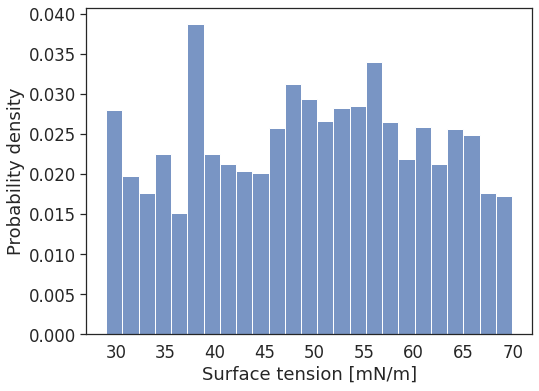

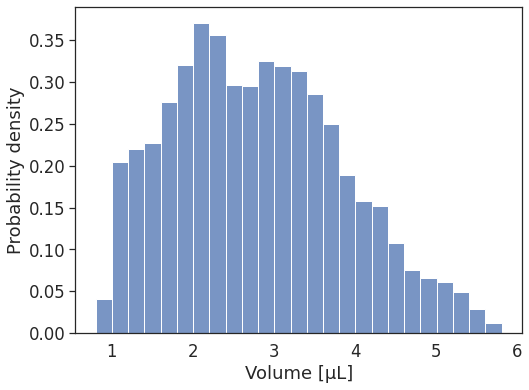

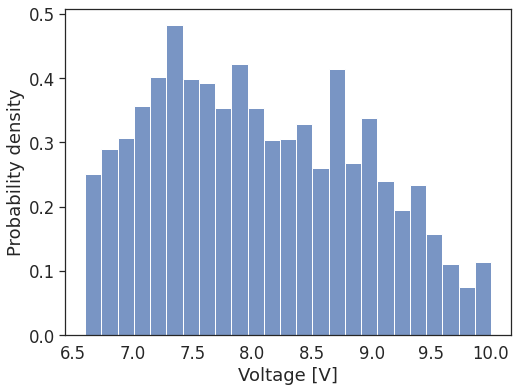

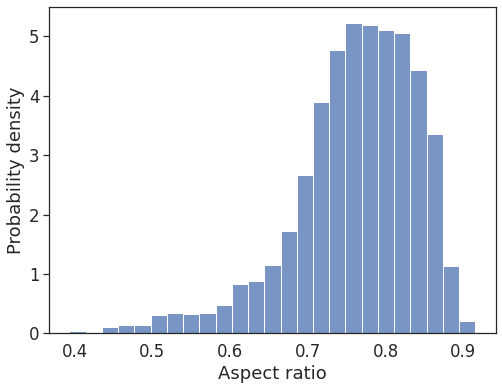

In [7]:
sns.set_theme(style='ticks', font_scale=1.5)

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/Experimental/Figures/'

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(dataset.loc[:, 'ST'], kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'exp_data_distr_ST_svg', dpi=300, format='svg')
  plt.savefig(path+'exp_data_distr_ST_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(dataset.loc[:, 'volume'], kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'exp_data_distr_Volume_svg', dpi=300, format='svg')
  plt.savefig(path+'exp_data_distr_Volume_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(dataset.loc[:, 'volt'], kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'exp_data_distr_Voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'exp_data_distr_Voltage_png', dpi=300, format='png')


plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(1/dataset.loc[:, 'Aspect_Ratio'], kde=False, bins=25, stat="density")
plt.xlabel('Aspect ratio')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'exp_data_distr_AR_svg', dpi=300, format='svg')
  plt.savefig(path+'exp_data_distr_AR_png', dpi=300, format='png')



### Remover selected features

In [67]:
dataset.pop("height")
dataset.pop("width")
# volume=dataset.pop("volume")
dataset.pop("R_sph")
dataset.pop('time')
Power=dataset.pop('Power')
dataset.pop("centre_x")
# AR=dataset.pop("Aspect_Ratio")
centre_z = dataset.pop("centre_z")

dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,phi_173,phi_174,volume,Aspect_Ratio,volt,current,centred_z,surfactant_conc,ST,surf_number
58364,0.752019,0.753423,0.751969,0.748898,0.748090,0.745630,0.743755,0.739546,0.736226,0.732583,...,3.098966,3.135,1.395802,1.267742,8.4,0.329,0.034708,1.328075,29.025006,2.0
58365,0.751976,0.753333,0.751833,0.747438,0.747859,0.745252,0.741373,0.738592,0.735435,0.732574,...,3.098966,3.135,1.396137,1.267742,8.4,0.329,0.038533,1.327757,29.025040,2.0
58366,0.750053,0.751397,0.749880,0.748385,0.745866,0.743335,0.741739,0.737198,0.733329,0.730433,...,3.098966,3.135,1.392782,1.264516,8.4,0.329,0.050008,1.330955,29.024693,2.0
58367,0.750083,0.747624,0.746127,0.745592,0.744952,0.743258,0.739445,0.736726,0.733616,0.728434,...,3.098966,3.135,1.391590,1.264516,8.4,0.329,0.034708,1.332096,29.024570,2.0
58368,0.750165,0.751629,0.750232,0.749803,0.746460,0.744051,0.741164,0.738500,0.734412,0.731644,...,3.098966,3.135,1.389240,1.264516,8.4,0.329,0.046183,1.334349,29.024326,2.0


### Check contours

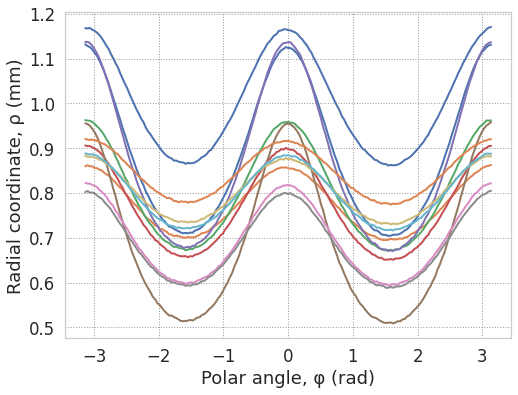

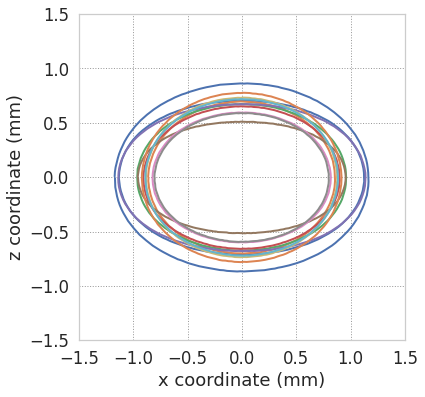

In [8]:
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})


n=0
rand_cont=np.array([0, 1500, 3000, 5000, 6000, 7500, 10000, 15000, 30000, 35000, 40000, 45000])
savefig=False

points=175

plt.figure(figsize=(8,6))
# plt.title('Polar coordinates')
for n in rand_cont:
  plt.plot(dataset.iloc[n, points:2*points], dataset.iloc[n, 0:points], linewidth=2)
plt.ylabel('Radial coordinate, ρ (mm)')
plt.xlabel('Polar angle, φ (rad)')
if savefig==True:
  plt.savefig(path+'polar_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'polar_contours_before_norm_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
# plt.title('Cartesian coordinates')
for i in rand_cont:
  x, y=pol2cart(dataset.iloc[i, 0:points].values, dataset.iloc[i, points:points*2].values)
  plt.plot(x, y, linewidth=2) 
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'Cart_contours_before_norm_svg', dpi=300, format='svg')
  plt.savefig(path+'Cart_contours_before_norm_png', dpi=300, format='png')


### Shuffle the data

<ipython-input-68-f006cd08bff9>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['droplet']=droplet_array


0         0
1         0
2         0
3         0
4         0
         ..
58364    46
58365    46
58366    46
58367    46
58368    46
Name: droplet, Length: 58369, dtype: object

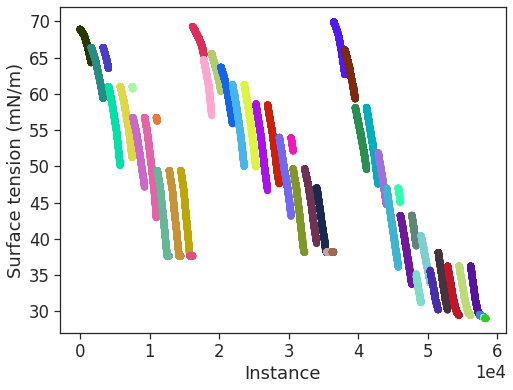

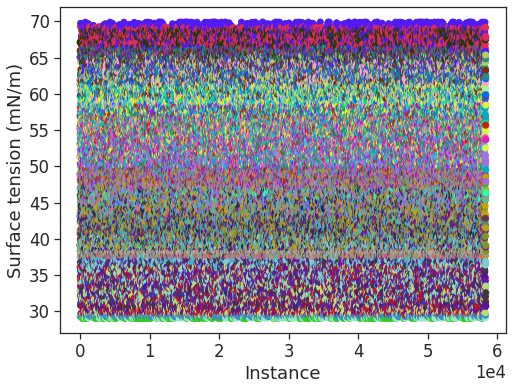

In [68]:
droplet_array=[]

droplets=[0, 1600, 3323, 4100, 5784, 7504, 7600, 9291, 10981, 11100, 12819, 14495, 15805, 16205,
          17805, 18938, 20257, 21927, 23614, 25292, 26977, 28655, 30344, 30655, 32304, 34028, 35483, 36283, 36483,
          38083, 39583, 41215, 42869, 44069, 45776, 46069, 47714, 48369, 49040, 50369, 51511, 52869, 54505, 56177, 57469, 58069, 58269, 58369]

for i in range(len(droplets)-1):
  droplet_array.append(np.repeat(i, droplets[i+1]-droplets[i]))


flat_list = []
for sublist in droplet_array:
    for item in sublist:
        flat_list.append(item)

droplet_array=np.reshape(flat_list, (len(flat_list), 1))


for i in range(len(droplets)):
  dataset['droplet']=droplet_array


### Visualize the shuffled data

droplet_str=[]
colors = []
keys=[]


for i in range(len(dataset)):
  droplet_str.append(str(dataset['droplet'][i]))

dataset['droplet']=droplet_str

for i in range(len(droplets)):
  colors.append('#%06X' % randint(0, 0xFFFFFF))
  keys.append(str(i))


droplet_dict=dict(zip(keys, colors))
# droplet_dict


### In case an error occurs during saving the second plot ###
# import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 10000

sns.set_theme(style='ticks', font_scale=1.5)
savefig=False


fig, ax = plt.subplots(figsize=(8, 6))
# plt.title('Before shuffling')
# for i in range(len(droplets)-1):
ax.scatter(range(len(dataset)), dataset.ST, marker='o', facecolors='none', c=dataset['droplet'].map(droplet_dict)) 
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')
if savefig==True:
  plt.savefig(path+'data_before_shuffling_colour_svg', dpi=300, format='svg')
  plt.savefig(path+'data_before_shuffling_colour_png', dpi=300, format='png')


dataset_sh=shuffle(dataset, random_state=0)


fig, ax = plt.subplots(figsize=(8, 6))
# plt.title('After shuffling')
ax.scatter(range(len(dataset_sh)), dataset_sh.ST, marker='o', facecolors='none', c=dataset_sh['droplet'].map(droplet_dict))
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'data_after_shufffling_colour_png', dpi=300, format='png')
  plt.savefig(path+'data_after_shufffling_colour_svg', dpi=300, format='svg')

dataset.pop('droplet')

# normed_data.tail()

### Min-Max transformation

In [69]:
dataset=dataset.reset_index()
dataset.pop('index')
dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,phi_173,phi_174,volume,Aspect_Ratio,volt,current,centred_z,surfactant_conc,ST,surf_number
58364,0.752019,0.753423,0.751969,0.748898,0.748090,0.745630,0.743755,0.739546,0.736226,0.732583,...,3.098966,3.135,1.395802,1.267742,8.4,0.329,0.034708,1.328075,29.025006,2.0
58365,0.751976,0.753333,0.751833,0.747438,0.747859,0.745252,0.741373,0.738592,0.735435,0.732574,...,3.098966,3.135,1.396137,1.267742,8.4,0.329,0.038533,1.327757,29.025040,2.0
58366,0.750053,0.751397,0.749880,0.748385,0.745866,0.743335,0.741739,0.737198,0.733329,0.730433,...,3.098966,3.135,1.392782,1.264516,8.4,0.329,0.050008,1.330955,29.024693,2.0
58367,0.750083,0.747624,0.746127,0.745592,0.744952,0.743258,0.739445,0.736726,0.733616,0.728434,...,3.098966,3.135,1.391590,1.264516,8.4,0.329,0.034708,1.332096,29.024570,2.0
58368,0.750165,0.751629,0.750232,0.749803,0.746460,0.744051,0.741164,0.738500,0.734412,0.731644,...,3.098966,3.135,1.389240,1.264516,8.4,0.329,0.046183,1.334349,29.024326,2.0


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [70]:
train_data = dataset.sample(frac=0.8,random_state=0)
test_data = dataset.drop(train_data.index)

#Reset index

train_data=train_data.reset_index()
index_train=train_data.pop('index')
volume_train=train_data.pop('volume')
Aspect_Ratio_train=train_data.pop('Aspect_Ratio')
surf_conc_train=train_data.pop('surfactant_conc')
surf_number_train=train_data.pop('surf_number')

test_data=test_data.reset_index()
index_test=test_data.pop('index')
volume_test=test_data.pop('volume')
Aspect_Ratio_test=test_data.pop('Aspect_Ratio')
surf_conc_test=test_data.pop('surfactant_conc')
surf_number_test=test_data.pop('surf_number')


### Scalling

In [76]:
#Scalling training dataset

new_df_train=MinMaxTransformTrain(dataset_train=train_data, points=175)
new_df_train.tail()


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,rho_165,rho_166,rho_167,rho_168,rho_169,rho_170,rho_171,rho_172,rho_173,rho_174
46690,0.426971,0.429182,0.428052,0.426121,0.424959,0.422964,0.422226,0.417940,0.414851,0.412972,...,0.407624,0.408679,0.412996,0.415144,0.418530,0.423149,0.424376,0.426875,0.426036,0.426485
46691,0.326212,0.327130,0.324554,0.323121,0.322835,0.320570,0.320992,0.319387,0.314060,0.311834,...,0.307891,0.311960,0.312750,0.316028,0.317665,0.321776,0.322317,0.324001,0.326828,0.326163
46692,0.256110,0.258129,0.256577,0.256080,0.256656,0.253568,0.251500,0.250461,0.248417,0.246588,...,0.240036,0.243563,0.246122,0.247827,0.249586,0.250541,0.252546,0.255598,0.255086,0.255643
46693,0.360382,0.362791,0.361767,0.361943,0.358621,0.356460,0.355469,0.353558,0.351716,0.349794,...,0.344521,0.345182,0.347289,0.349971,0.354084,0.354698,0.356498,0.359485,0.359045,0.359804
46694,0.304729,0.302982,0.302896,0.300680,0.301574,0.298872,0.294281,0.291891,0.287807,0.284587,...,0.281448,0.283861,0.287343,0.292209,0.293792,0.299228,0.301109,0.304101,0.303596,0.304220


In [77]:
#Scalling test dataset based on training dataset

new_df_test=MinMaxTransformTest(test_data, train_data, points=175)
new_df_test.tail()



,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,rho_165,rho_166,rho_167,rho_168,rho_169,rho_170,rho_171,rho_172,rho_173,rho_174
11669,0.345216,0.342232,0.345081,0.342371,0.340288,0.337253,0.335354,0.332764,0.330118,0.326168,...,0.319640,0.322076,0.326992,0.330854,0.333311,0.337798,0.338985,0.341335,0.344850,0.344900
11670,0.342850,0.344464,0.342605,0.341915,0.339956,0.339336,0.336941,0.331789,0.331336,0.326785,...,0.318946,0.323596,0.328816,0.332112,0.335649,0.340201,0.341435,0.343730,0.342551,0.342553
11671,0.349775,0.349210,0.349470,0.346433,0.344531,0.341433,0.339472,0.336080,0.330142,0.325736,...,0.321371,0.326353,0.332388,0.334735,0.338212,0.342813,0.343885,0.346127,0.349540,0.349494
11672,0.340280,0.341547,0.339338,0.338292,0.338417,0.334989,0.331128,0.326699,0.325053,0.320253,...,0.314210,0.319893,0.324811,0.327725,0.330176,0.334535,0.337623,0.337320,0.340453,0.340113
11673,0.347622,0.344733,0.343014,0.342467,0.339255,0.337292,0.333599,0.329535,0.327585,0.320198,...,0.317350,0.322550,0.325393,0.331348,0.335028,0.339826,0.341095,0.343529,0.347133,0.347276


In [78]:
points=175

if train_data.shape[1]>2*points:
  stats = train_data.iloc[:, 2*points:].describe() 
else:
  stats = train_data.iloc[:, points:].describe() 
# stats.pop("ST")

stats = stats.transpose()
stats


,count,mean,std,min,25%,50%,75%,max
volume,46695.0,2.808073,1.058135,0.806276,1.986456,2.741218,3.528142,5.804877
Aspect_Ratio,46695.0,1.332016,0.169329,1.092391,1.220447,1.297203,1.387097,2.541502
volt,46695.0,8.063710,0.857414,6.600000,7.340000,7.970000,8.750000,10.000000
current,46695.0,0.312764,0.019648,0.272000,0.296000,0.312000,0.329000,0.366000
centred_z,46695.0,0.001997,0.094150,-0.323581,-0.069027,0.020304,0.080019,0.244943
surfactant_conc,46695.0,1.589261,2.576058,0.014982,0.193732,0.379222,1.614508,15.290826
ST,46695.0,49.504606,11.279460,29.024210,39.751155,49.820528,58.573276,69.925068
surf_number,46695.0,1.096863,0.801454,0.000000,0.000000,1.000000,2.000000,2.000000



#### Normalize the rest of the features

In [79]:
def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

if train_data.shape[1]>2*points:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, 2*points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, 2*points:])   #iloc[:, 2*points:]
else:
  normed_train_data_rest = min_max_norm(train_data.iloc[:, points:]) #iloc[:, 2*points:]
  normed_test_data_rest = min_max_norm(test_data.iloc[:, points:])   #iloc[:, 2*points:]


In [80]:
#Putting scalled training dataset together

normed_train_data = new_df_train.copy()

normed_train_data['centred_z'] = normed_train_data_rest.centred_z
normed_train_data['volt'] = normed_train_data_rest.volt
normed_train_data['current'] = normed_train_data_rest.current
normed_train_data['ST'] = normed_train_data_rest.ST

normed_train_data.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,rho_169,rho_170,rho_171,rho_172,rho_173,rho_174,centred_z,volt,current,ST
46690,0.426971,0.429182,0.428052,0.426121,0.424959,0.422964,0.422226,0.417940,0.414851,0.412972,...,0.418530,0.423149,0.424376,0.426875,0.426036,0.426485,0.294091,0.023529,0.053191,0.224020
46691,0.326212,0.327130,0.324554,0.323121,0.322835,0.320570,0.320992,0.319387,0.314060,0.311834,...,0.317665,0.321776,0.322317,0.324001,0.326828,0.326163,0.372809,0.050000,0.095745,0.007226
46692,0.256110,0.258129,0.256577,0.256080,0.256656,0.253568,0.251500,0.250461,0.248417,0.246588,...,0.249586,0.250541,0.252546,0.255598,0.255086,0.255643,0.387228,0.182353,0.255319,0.017301
46693,0.360382,0.362791,0.361767,0.361943,0.358621,0.356460,0.355469,0.353558,0.351716,0.349794,...,0.354084,0.354698,0.356498,0.359485,0.359045,0.359804,0.360788,0.000000,0.042553,0.134176
46694,0.304729,0.302982,0.302896,0.300680,0.301574,0.298872,0.294281,0.291891,0.287807,0.284587,...,0.293792,0.299228,0.301109,0.304101,0.303596,0.304220,0.655452,0.317647,0.340426,0.065227


In [18]:
#Putting scalled test dataset together

normed_test_data = new_df_test.copy()

normed_test_data['centred_z'] = normed_test_data_rest.centred_z
normed_test_data['volt'] = normed_test_data_rest.volt
normed_test_data['current'] = normed_test_data_rest.current
normed_test_data['ST'] = normed_test_data_rest.ST

normed_test_data.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,rho_169,rho_170,rho_171,rho_172,rho_173,rho_174,centred_z,volt,current,ST
11669,0.345216,0.342232,0.345081,0.342371,0.340288,0.337253,0.335354,0.332764,0.330118,0.326168,...,0.333311,0.337798,0.338985,0.341335,0.344850,0.344900,0.495654,0.420588,0.500000,0.000128
11670,0.342850,0.344464,0.342605,0.341915,0.339956,0.339336,0.336941,0.331789,0.331336,0.326785,...,0.335649,0.340201,0.341435,0.343730,0.342551,0.342553,0.512473,0.420588,0.500000,0.000108
11671,0.349775,0.349210,0.349470,0.346433,0.344531,0.341433,0.339472,0.336080,0.330142,0.325736,...,0.338212,0.342813,0.343885,0.346127,0.349540,0.349494,0.566296,0.444118,0.521277,0.000103
11672,0.340280,0.341547,0.339338,0.338292,0.338417,0.334989,0.331128,0.326699,0.325053,0.320253,...,0.330176,0.334535,0.337623,0.337320,0.340453,0.340113,0.670576,0.464706,0.521277,0.000040
11673,0.347622,0.344733,0.343014,0.342467,0.339255,0.337292,0.333599,0.329535,0.327585,0.320198,...,0.335028,0.339826,0.341095,0.343529,0.347133,0.347276,0.643665,0.508824,0.585106,0.000013


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [19]:


train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')




## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

### Define neural network architecture

In [37]:
from numpy.random import seed

sseed=7 
def build_model(sseed=sseed):
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(50, activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]),  #, kernel_regularizer='l2'
    layers.Dense(40, activation=tf.nn.softplus),
    layers.Dense(30, activation=tf.nn.swish),
    layers.Dense(20, activation=tf.nn.softplus), 
    layers.Dense(15, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',  #custom_loss,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()

In [38]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 50)                8950      
                                                                 
 dense_33 (Dense)            (None, 40)                2040      
                                                                 
 dense_34 (Dense)            (None, 30)                1230      
                                                                 
 dense_35 (Dense)            (None, 20)                620       
                                                                 
 dense_36 (Dense)            (None, 15)                315       
                                                                 
 dense_37 (Dense)            (None, 10)                160       
                                                                 
 dense_38 (Dense)            (None, 5)                


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [39]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 264ms/step


array([[0.6012699 ],
       [0.58823514],
       [0.5978888 ],
       [0.59491205],
       [0.57932603],
       [0.57953095],
       [0.6009749 ],
       [0.5839341 ],
       [0.5910604 ],
       [0.5872529 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for up to 2000 epochs, and record the training and validation accuracy in the `history` object. The model with the best weights is saved.

In [40]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=0, restore_best_weights=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................

### Training history and performance

Visualize the model's training progress using the stats stored in the `history` object.

In [48]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
914,0.002327,0.031132,0.002327,0.003091,0.036438,0.003091,914
915,0.002682,0.032910,0.002682,0.002319,0.030197,0.002319,915
916,0.002387,0.031315,0.002387,0.003182,0.035190,0.003182,916
917,0.002246,0.030693,0.002246,0.002057,0.028609,0.002057,917
918,0.002198,0.030132,0.002198,0.002495,0.030769,0.002495,918


In [49]:
min_train_error=find_nearest(hist.mean_squared_error, min(hist.mean_squared_error))
min_val_error=find_nearest(hist.val_mean_squared_error, min(hist.val_mean_squared_error))

if min_val_error[1] > min_train_error[1]:
  min_train_val_diff=find_nearest(hist.val_mean_squared_error[ min_train_error[1]: min_val_error[1]]-hist.mean_squared_error[ min_train_error[1]: min_val_error[1]], min(abs(hist.val_mean_squared_error[ min_train_error[1]: min_val_error[1]]-hist.mean_squared_error[ min_train_error[1]: min_val_error[1]])))
elif min_val_error[1] < min_train_error[1]:
  min_train_val_diff=find_nearest(hist.val_mean_squared_error[ min_val_error[1]: min_train_error[1]]-hist.mean_squared_error[ min_val_error[1]: min_train_error[1]], min(abs(hist.val_mean_squared_error[ min_val_error[1]: min_train_error[1]]-hist.mean_squared_error[ min_val_error[1]: min_train_error[1]])))
else:
  min_train_val_diff=min_val_error


print('Min train MSE: %.8f, index: %d' %(min_train_error[0], min_train_error[1]))

print('Min val MSE: %.8f, index: %d' %(min_val_error[0], min_val_error[1]))

print('Diff train-val MSE at min val MSE %.8f: '%(hist.mean_squared_error[min_val_error[1]] - min_val_error[0]))

if min_val_error[1] > min_train_error[1]:
  idx=min_train_error[1] + min_train_val_diff[1]
  print('Min diff train-val MSE: %.8f, index: %d, train MSE: %.8f' %(min_train_val_diff[0],  idx, hist.mean_squared_error[idx]))
elif min_val_error[1] < min_train_error[1]:
  idx=min_val_error[1] + min_train_val_diff[1]
  print('Min diff train-val MSE: %.8f, index: %d, train MSE: %.8f' %(min_train_val_diff[0],  idx, hist.mean_squared_error[idx]))
else:
  print('Min diff train-val MSE: %.8f, index: %d' %(min_train_val_diff[0],  min_val_error[1] + min_train_val_diff[1]))




Min train MSE: 0.00140901, index: 904
Min val MSE: 0.00144514, index: 818
Diff train-val MSE at min val MSE 0.00034539: 
Min diff train-val MSE: 0.00001559, index: 824, train MSE: 0.00176349


In [50]:
## Re-scale target feature
def rescaling(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

ST_real_test=rescaling(test_labels)
ST_pred_test=rescaling(test_predictions)

ST_real_train=rescaling(train_labels)
ST_pred_train=rescaling(train_predictions)  

#Re-scalling check:
# plt.figure(figsize=(8,6))
# plt.scatter(range(len(test_labels)), test_labels)
# plt.ylabel('Normalizaed surface tension')
# plt.xlabel('Instances')

# plt.figure(figsize=(8,6))
# plt.scatter(range(len(ST_real_test)), ST_real_test)
# plt.ylabel('Surface tension (mN/m)')
# plt.xlabel('Instances')

1460/1460 [==============================] - 2s 2ms/step


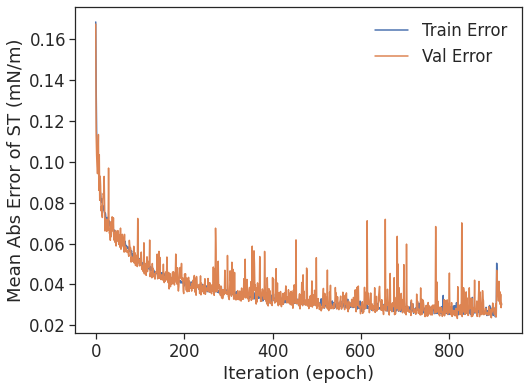

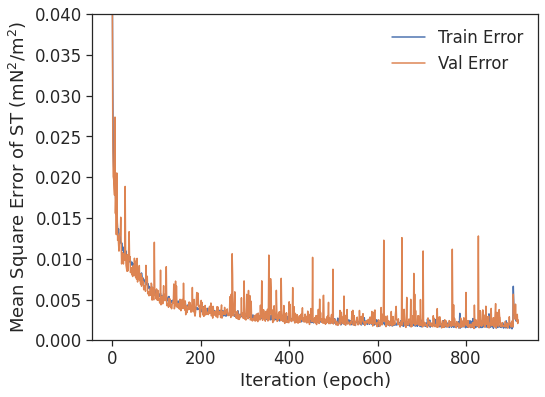

In [51]:
def plot_history(history, savefig=True, path=''):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  sns.set_theme(style='ticks', font_scale=1.5)
  
  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  # plt.ylim([0,0.2])
  plt.legend(frameon=False)
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MAE_png', dpi=300, format='png')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,0.04])
  plt.legend(frameon=False)
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_svg', dpi=300, format='svg')
    plt.savefig(path+'training_outcome_MSE_png', dpi=300, format='png')

path='/content/drive/My Drive/DropLev/for_draft/Experimental/Figures/'

plot_history(history, savefig=False, path=path)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

### Make predictions

Finally, predict ST values using data in the testing set:

In [52]:
def density_scatter(x, y, title=None, label=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(8,8)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  if title!=None:
    plt.title(title)
  im=ax.scatter(x, y, label=label, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')


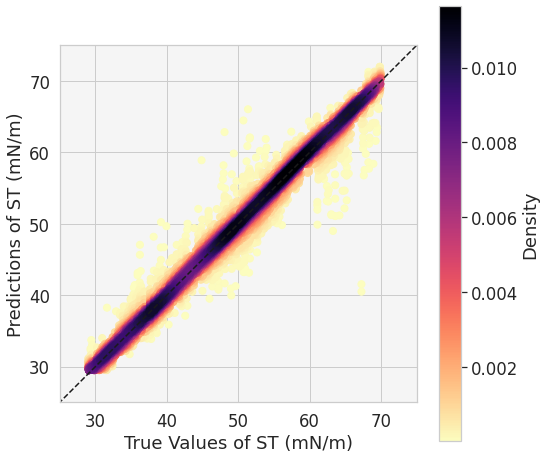

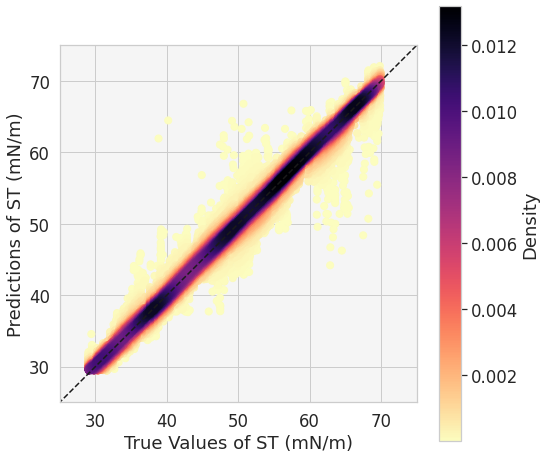

In [53]:

savefig=False

sns.set_theme(style='whitegrid', font_scale=1.5, color_codes=False)

colours='magma_r'


density_scatter(ST_real_test, ST_pred_test, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], '--k')
plt.xlim(25, 75)
plt.ylim(25, 75)
if savefig==True:
  plt.savefig(path+'test_data_error_plot_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_plot_png', dpi=300, format='png')


density_scatter(ST_real_train, ST_pred_train, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], '--k')
plt.xlim(25, 75)
plt.ylim(25, 75)
if savefig==True:
  plt.savefig(path+'training_data_error_plot_svg', dpi=300, format='svg')
  plt.savefig(path+'training_data_error_plot_png', dpi=300, format='png')




Error distribution

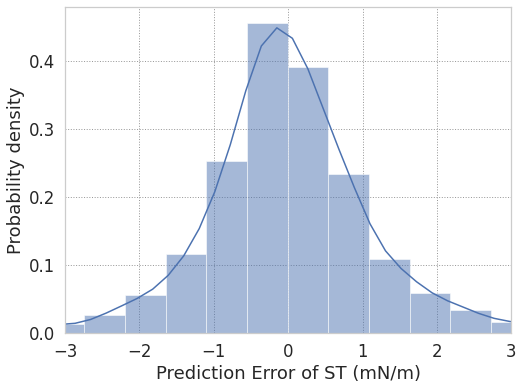

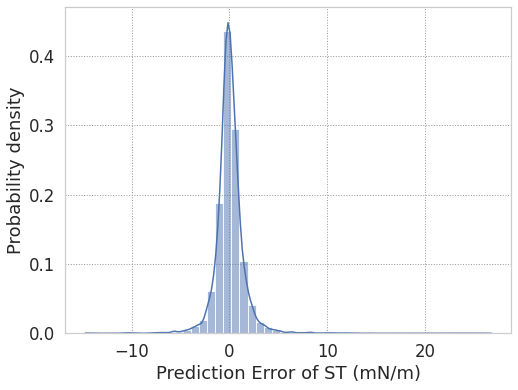

In [54]:
error_test = ST_real_test - ST_pred_test

sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
savefig=False

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 76, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_distr_lim_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_distr_lim_png', dpi=300, format='png')

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_distr_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_distr_png', dpi=300, format='png')



In [55]:
#Confidence:
error_test_test=np.asarray(error_test)

rows_05=error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)]
rows_1=error_test_test[(error_test_test >= -1) & (error_test_test <= 1)]
rows_2=error_test_test[(error_test_test >= -2) & (error_test_test <= 2)]


### The prediction error can vary based on:
### -  training data
### -  architecture of model (number of neurons, number of layers, activation functions, etc.)
### - ''sseed'' variable (which defines the initialization point) 


print('Confidence for error '+u"\u00B1"+' 0.5 mN/m: %.2f' %int(len(rows_05)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 1 mN/m: %.2f' %int(len(rows_1)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 2 mN/m: %.2f' %int(len(rows_2)/len(error_test)*100)+ ' %')

print('Mean Absolute error: %.2f mN/m' %(sum(abs(error_test_test))/len(error_test_test)))


Confidence for error ± 0.5 mN/m: 43.00 %
Confidence for error ± 1 mN/m: 69.00 %
Confidence for error ± 2 mN/m: 89.00 %
Mean Absolute error: 0.94 mN/m


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

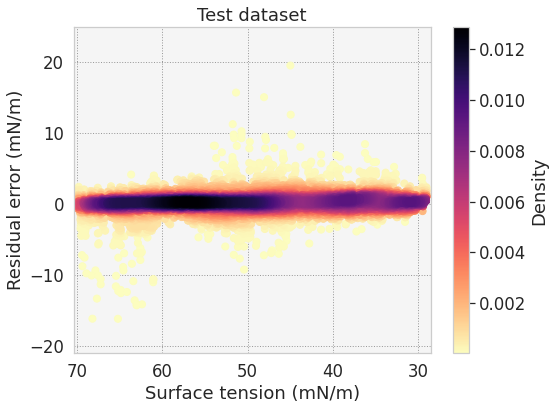

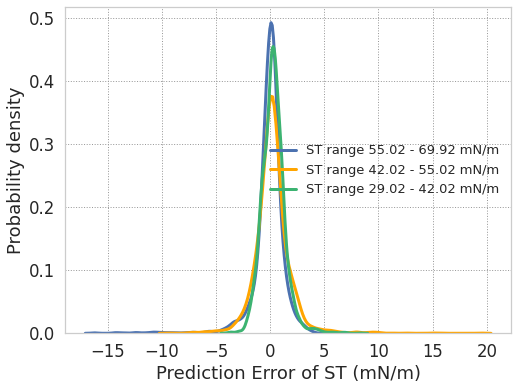

In [36]:
savefig=False


error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

density_scatter(ST_real_test, error_test, title='Test dataset', colours=colours, eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.xlim(min(ST_real_train)-0.5, max(ST_real_train)+0.5)
plt.gca().invert_xaxis()
plt.ylabel('Residual error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_test_data_'+figtype, dpi=300, format=figtype)


# density_scatter(ST_real_train, error_train, title='Train dataset', colours=colours, eq_sq=False, figsize=(8,6))
# plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
# plt.xlim(min(ST_pred_test)-0.5, max(ST_pred_test)+0.5)
# plt.gca().invert_xaxis()
# plt.ylabel('Residual error (mN/m)')
# plt.xlabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'error_Vs_ST_training_data_'+figtype, dpi=300, format=figtype)


check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

# sns.set_theme(style='ticks', font_scale=1.5)

# density_scatter(range(len(sorted_st)), sorted_st.True_values, title='Real values', colours=colours, eq_sq=False, figsize=(10,6))
# plt.xlabel('Instance')
# plt.ylabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'real_test_St_sorted_svg', dpi=300, format='svg')
#   plt.savefig(path+'real_test_St_sorted_png', dpi=300, format='png')

# density_scatter(range(len(sorted_st)), sorted_st.Predictions, title='Predicted values', colours=colours,  eq_sq=False, figsize=(10,6))
# plt.xlabel('Instance')
# plt.ylabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'pred_test_St_sorted_svg', dpi=300, format='svg')
#   plt.savefig(path+'pred_test_St_sorted_png', dpi=300, format='png')


# density_scatter(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values, title='Prediction error', colours=colours,  eq_sq=False, figsize=(10,6))
# plt.xlabel('Instance')
# plt.ylabel('Surface tension (mN/m)')
# if savefig==True:
#   plt.savefig(path+'pred_error_test_St_sorted_svg', dpi=300, format='svg')
#   plt.savefig(path+'pred_error_test_St_sorted_png', dpi=300, format='png')


step=int((max(sorted_st.True_values)-min(sorted_st.True_values))/3)

trial_1=sorted_st.loc[(sorted_st['True_values'] >= min(sorted_st.True_values)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step))]
trial_2=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step*2))]
trial_3=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step*2)) & (sorted_st['True_values'] <= max(sorted_st.True_values))]

thickness=3
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
sns.distplot(trial_3.Predictions-trial_3.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step*2, max(sorted_st.True_values)))
sns.distplot(trial_2.Predictions-trial_2.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='orange', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step, min(sorted_st.True_values)+step*2))
sns.distplot(trial_1.Predictions-trial_1.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='mediumseagreen', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values), min(sorted_st.True_values)+step))
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
# plt.xlim(-5, 5)
if savefig==True:
  plt.savefig(path+'test_data_error_distr_steps_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_distr_steps_png', dpi=300, format='png')



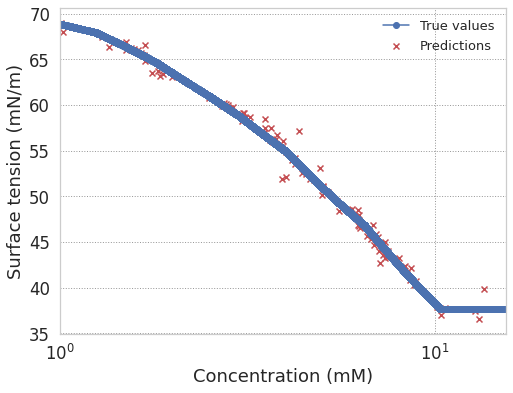

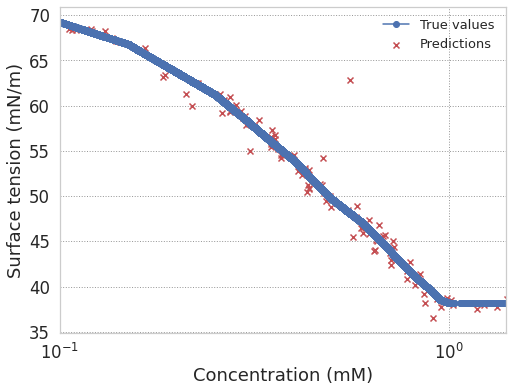

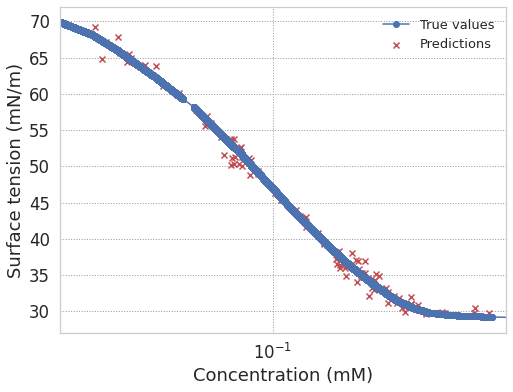

In [75]:

savefig=False
date=20220329



#Define data-frames with ST, concentration and surfactant number for the dataset + error for the predictions
table_data=pd.DataFrame(np.vstack([dataset.ST, dataset.surfactant_conc, dataset.surf_number]).T, columns=['ST', 'surf_conc', 'surf_number'])
table_pred=pd.DataFrame(np.vstack([ST_pred_test, surf_conc_test, error_test, surf_number_test]).T, columns=['ST_pred', 'conc', 'error', 'surf_number'])

#Sort datasets based on concentration
sorted_data=table_data.sort_values(by=['surf_conc'], ascending=True)
Predictions=table_pred.sort_values(by=['conc'], ascending=True)


#Separate ST and concentration values of each surfactant
data_SDS=sorted_data[sorted_data.surf_number==0]
data_CTAB=sorted_data[sorted_data.surf_number==1]
data_TX100=sorted_data[sorted_data.surf_number==2]


#Separate predictions of each surfactant
pred_SDS=Predictions[Predictions.surf_number==0]
pred_CTAB=Predictions[Predictions.surf_number==1]
pred_TX100=Predictions[Predictions.surf_number==2]

#Randmolly choose n amount of points
seed=5
n=100
plotted_pred_SDS=pred_SDS.sample(n, random_state=seed)
plotted_pred_CTAB=pred_CTAB.sample(n, random_state=seed)
plotted_pred_TX100=pred_TX100.sample(n, random_state=seed)


#Plot isotherm of each surfactant
plt.figure(figsize=(8,6))
plt.semilogx(data_SDS.surf_conc, data_SDS.ST, '-o',  label='True values')
plt.scatter(plotted_pred_SDS.conc, plotted_pred_SDS.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(1, 15.5)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'SDS_isotherm_predictions_%d_svg' %date, dpi=300, format='svg')
  plt.savefig(path+'SDS_isotherm_predictions_%d_png' %date, dpi=300, format='png')



plt.figure(figsize=(8,6))
plt.semilogx(data_CTAB.surf_conc, data_CTAB.ST, '-o', label='True values')
plt.scatter(plotted_pred_CTAB.conc, plotted_pred_CTAB.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.1, 1.4)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'CTAB_isotherm_predictions_%d_svg' %date, dpi=300, format='svg')
  plt.savefig(path+'CTAB_isotherm_predictions_%d_png' %date, dpi=300, format='png')


plt.figure(figsize=(8,6))
plt.semilogx(data_TX100.surf_conc, data_TX100.ST, '-o',  label='True values')
plt.scatter(plotted_pred_TX100.conc, plotted_pred_TX100.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.015, 0.8)
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'TX100_isotherm_predictions_%d_svg' %date, dpi=300, format='svg')
  plt.savefig(path+'TX100_isotherm_predictions_%d_png' %date, dpi=300, format='png')


# ST_lim1=0.15 # TritonX: 0.45, SDS: 6   CTAB: 0.85
# ST_lim2=0.28  # TritonX: 0.80, SDS: 9.5   CTAB: 0.95

# ST_lim3=0.3 # TritonX: 0.9, SDS:10.2   CTAB: 1
# ST_lim4=0.6  # TritonX: 1.2, SDS:12.7   CTAB: 1.3

# lower=Predictions[(Predictions['conc'] > ST_lim1) & (Predictions['conc'] <ST_lim2)]
# higher=Predictions[(Predictions['conc'] > ST_lim3) & (Predictions['conc'] <ST_lim4)]

# slope1, intercept1, r1, p1, se1 = linregress(lower.conc, lower.ST_pred)
# slope2, intercept2, r2, p2, se2 = linregress(higher.conc, higher.ST_pred)

# cross_conc=(intercept2-intercept1)/(slope1-slope2)
# cross_ST=slope2*cross_conc+intercept2

# plt.figure(figsize=(8,6))
# density_scatter(Predictions.conc, Predictions.ST_pred, colours=colours,  eq_sq=False, figsize=(10,6))
# plt.plot(lower.conc, slope1*lower.conc+intercept1, '--', color='#577dc6', linewidth=3.5)
# plt.plot(higher.conc, slope2*higher.conc+intercept2, '--', color='#577dc6', linewidth=3.5)
# plt.plot(cross_conc, cross_ST, 'o', color='#577dc6', markersize=12, label='CMC=%.3f mM' %cross_conc)
# # plt.ylim(35,42)
# plt.ylabel('Surface tension (mN/m)')
# plt.xlabel('Concentration (mM)')
# plt.legend(loc='upper right', frameon=False)
# if savefig==True:
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_svg' %file, dpi=300, format='svg')
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_png' %file, dpi=300, format='png')

####### Error bars #######

# conc_lim=0.1  #TritonX: 0.005, SDS: 0.1, CTAB: 0.005
# error_bars=5
# sorted_predictions= Predictions.ST_pred.sort_values(ignore_index=True,  ascending=False)
# errorx=np.linspace(min(Predictions['conc']), max(Predictions['conc']), error_bars)

# yerror_range={}
# yerror=[]
# errory=[]

# for i in range(len(errorx)):
#   yerror_range[i]=Predictions[(Predictions['conc'] > errorx[i]-conc_lim) & (Predictions['conc'] <errorx[i]+conc_lim)].ST_pred
#   yerror.append((max(yerror_range[i])-min(yerror_range[i]))/2)
#   errory.append(np.mean(yerror_range[i]))


# yerror=np.asarray(yerror)
# errory=np.asarray(errory)

# plt.figure(figsize=(8,6))
# plt.plot(Predictions.conc, sorted_predictions, 'b')
# plt.plot(lower.conc, slope1*lower.conc+intercept1, '--k', linewidth=3)
# plt.plot(higher.conc, slope2*higher.conc+intercept2, '--k', linewidth=3)
# plt.plot(cross_conc, cross_ST, 'or', label='CMC=%.3f' %cross_conc)
# plt.errorbar(errorx, errory, yerr=yerror,  fmt='.k')
# plt.xlabel('Instances',fontsize=14)
# plt.ylabel('Surface tension (mN/m)',fontsize=18)
# plt.legend(loc='upper right', frameon=False)
# if savefig==True:
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_svg' %file, dpi=300, format='svg')
#   plt.savefig(path+'file_%s_ST_conc_instance_with_CMC_error_bars_50percent_png' %file, dpi=300, format='png')



### Save prediction outcome in a csv file

In [ ]:
#Save prediction outcome in a csv file

# error_test = ST_pred_test - ST_real_test
# error_train = ST_pred_train - ST_real_train
outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=['Train_labels', 'Train_pred'])
outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])

date=str('20220329')
surf='SDS_CTAB_TX100' #SDS_CTAB_ TX100
# model_No=2
data_No=55710
error='088'
training=1

path='/content/drive/My Drive/DropLev/for_draft/Experimental/'

filename=str('data_%s_%d_MSE_%s_%s_final.csv' %(surf, data_No, error, date))
# !mkdir -p '/content/drive/My Drive/DropLev/Outcomes/' #Ceates a folder named "MachineLearningModels"
outcome_train.to_csv(path+'train_out_%d_'%training+filename, index=False)  #Saves the file
outcome_test.to_csv(path+'test_out_%d_' %training+filename, index=False)  #Saves the file

hist.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'history_%d_' %training + filename)


### Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
path=str('/content/drive/My Drive/DropLev/for_draft/Experimental/')

date=20220329
surf='SDS_CTAB_TX100' #SDS_CTAB_TX100
# number=2
training=1
MAE='088'

filename=str('Model_saved_%s_train_%d_MAE_%s_%d_final.h5' %(surf, training, MAE, date))
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save(path+filename)  #Saves the file

### Feature importance

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

ST_pred_test=rescaling(test_predictions)


In [ ]:

error_test = ST_real_test - ST_pred_test
error_test_test=np.asarray(error_test)

print('Mean Absolute error: %.2f mN/m' %(sum(abs(error_test_test))/len(error_test_test)))


Mean Absolute error: 0.88 mN/m


In [ ]:
#Import trained model
from tensorflow.keras.models import load_model

path=str('/content/drive/My Drive/DropLev/for_draft/Experimental/')
date=20220329
surf='SDS_CTAB_TX100' #SDS_CTAB_TX100
# number=2
training=1
MAE='088'

filename=str(path+'Model_saved_%s_train_%d_MAE_%s_%d_final.h5' %(surf, training, MAE, date))

model=load_model(filename)

#Define MAE from the original training
mae=0.88

#Define number of features/columns
featureNum=normed_test_data.shape[1]

#Define feature/column names
ColumnName=normed_test_data.columns

#Rescalling test labels
ST_real_test=rescaling(test_labels)

#Define a dictionary to save the error
error_test={}
MAE={}
Conf_05={}
Conf_1={}
Conf_2={}

for i in range(featureNum):
  feature=normed_test_data.iloc[:, i]

  for j in range(0, 100, 33):
    # seed(j)
    # tf.random.set_seed(j)

    #Shuffle one feature j times
    shuffled_feature=shuffle(feature, random_state=j)
    #Reset the indexes of the new column
    shuffled_feature.reset_index(drop=True, inplace=True)

    #Copy the normalized test Dataframe into a new Dataframe
    shuffled_test=normed_test_data.copy()

    #Replace feature with shuffled feature
    shuffled_test[ColumnName[i]]=shuffled_feature

    #Predict on the test data with the shuffled feature
    test_predictions = model.predict(shuffled_test).flatten()

    #Rescalling test predictions with shuffled feature
    ST_pred_test=rescaling(test_predictions)

    error_test[i, j] = ST_real_test - ST_pred_test

    MAE[i, j]=(sum(abs(error_test[i, j]))/len(error_test[i, j]))-mae

    rows_05=error_test[i, j][(error_test[i, j] >= -0.5) & (error_test[i, j] <= 0.5)]
    rows_1=error_test[i, j][(error_test[i, j] >= -1) & (error_test[i, j] <= 1)]
    rows_2=error_test[i, j][(error_test[i, j] >= -2) & (error_test[i, j] <= 2)]

    Conf_05[i, j]=int(len(rows_05)/len(error_test[i, j])*100)
    Conf_1[i, j]=int(len(rows_1)/len(error_test[i, j])*100)
    Conf_2[i, j]=int(len(rows_2)/len(error_test[i, j])*100)






In [ ]:
trial=pd.DataFrame.from_dict(MAE, orient='index')

trial=np.asarray(trial, dtype=object)

j=0
Mean=[]
Min=[]
Max=[]
Std=[]
step=int(len(trial)/featureNum)
for i in range(featureNum):
  Mean.append(np.mean(trial[j:j+step]))
  Min.append(min(trial[j:j+step]))
  Max.append(max(trial[j:j+step]))
  Std.append(np.std(trial[j:j+step]))
  j=j+step



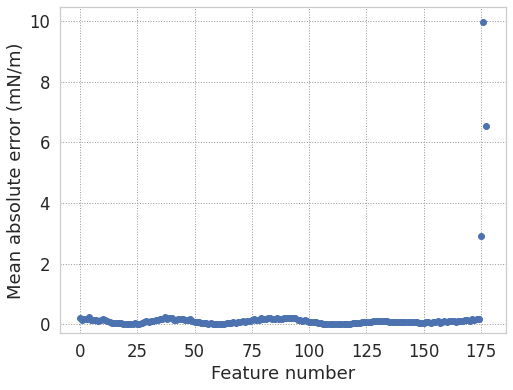

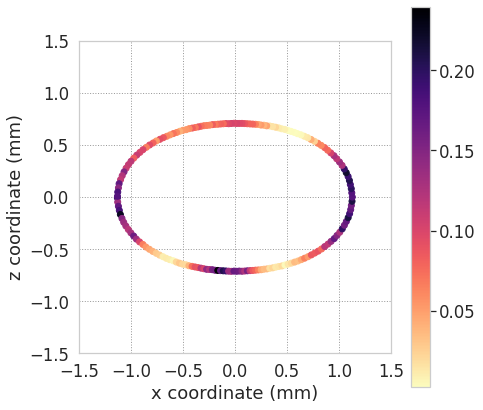

In [ ]:
import matplotlib
savefig=True

# xticks=[0, 158, 174, 175, 249, 349, 350, 351]
# xticksnames=ColumnName[xticks]

# mae=sum(abs(error_test_test))/len(error_test_test)

Mean_array=np.asarray(Mean)

plt.figure(figsize=(8, 6))
# plt.plot(range(175), Mean[175:350], 'bo')
plt.plot(Mean_array, 'bo')
# plt.plot(range(350, len( Mean)), Mean[350:], 'bo')

# plt.plot(range(featureNum), Mean, 'o')
# plt.xticks(xticks, xticksnames, rotation=90)
plt.xlabel('Feature number')
plt.ylabel('Mean absolute error (mN/m)')
# plt.xlim(349.2, 352)
plt.ylim(-0.3, )
if savefig==True:
  plt.savefig(path+'features_Vs_MAE_exp_svg', dpi=300, format='svg')
  plt.savefig(path+'features_Vs_MAE_exp_png', dpi=300, format='png')

# theta=raw_dataset.iloc[:, 350:525]

# for i in range(80,160, 1):
#   theta.pop('theta_%d' %i)

z_min=min(Mean_array[0:points])
z_max=max(Mean_array[0:points])
fig, ax=plt.subplots(figsize=(7,7))
norm=matplotlib.colors.Normalize(z_min, z_max) #vmin=min(data.Z_center), vmax=max(data.Z_center)
x, y=pol2cart(test_data.iloc[0, 0:175].values, raw_dataset.iloc[0, 175:350].values)
im=plt.scatter(x,y, c=Mean_array[0:points], norm=norm, cmap='magma_r')
plt.colorbar(im, ax=ax)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')
if savefig==True:
  plt.savefig(path+'feature_importance_coloured_coords_exp_svg', dpi=300, format='svg')
  plt.savefig(path+'feature_importance_coloured_coords_exp_png', dpi=300, format='png')

# plt.figure()
# for i in range(featureNum):
#   plt.errorbar(x=i, y=Mean_array[i], yerr=(Max[i]-Min[i]))
# plt.ylim(0.7, 1.5)

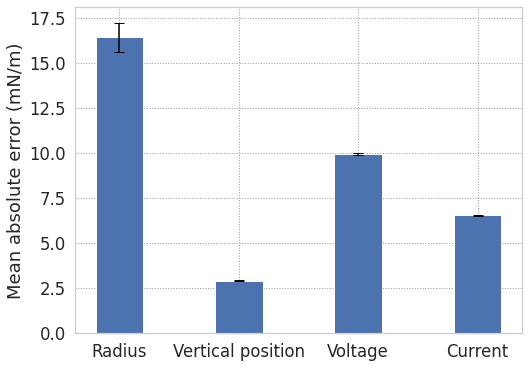

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

savefig=True

xlabels = ['Radius', 'Vertical position', 'Voltage', 'Current']
y = np.array([sum(Mean_array[0:175]), Mean_array[175],Mean_array[176], Mean_array[177]])

error = [sum(Std[0:175]), Std[175],Std[176], Std[177]]


plt.figure(figsize=(8,6))
plt.bar(xlabels, y, yerr=error, ecolor='black', capsize=5, align='center', width=0.4)
# plt.xticks(xlabels)
# plt.xlabel("Feature")
_ = plt.ylabel("Mean absolute error (mN/m)")
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'feature_importance_error_bars_svg', dpi=300, format='svg')
  plt.savefig(path+'feature_importance_error_bars_png', dpi=300, format='png')


## Error analysis



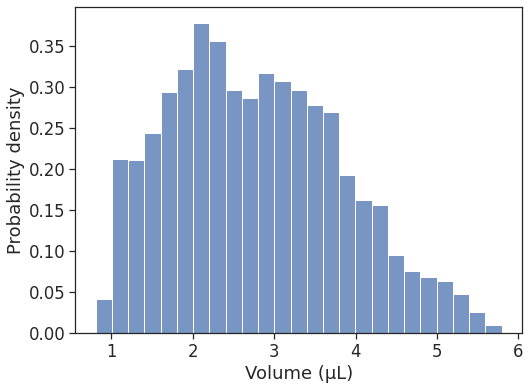

<Figure size 576x432 with 0 Axes>

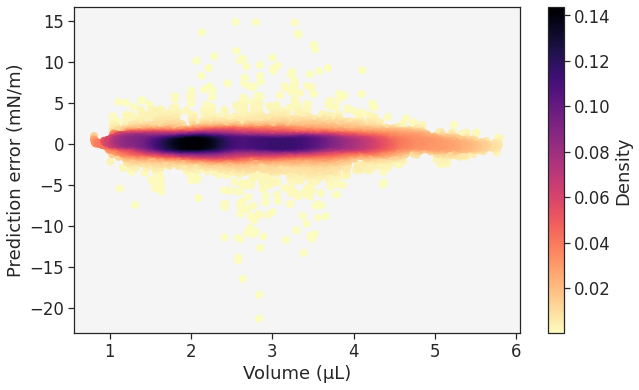

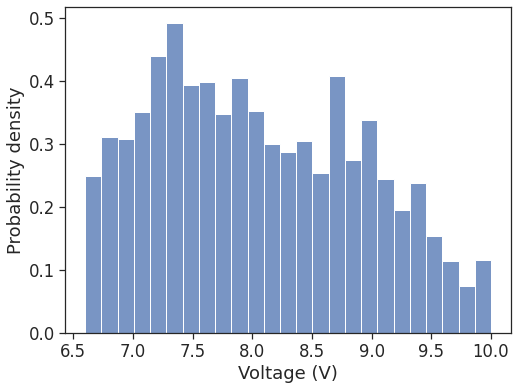

<Figure size 576x432 with 0 Axes>

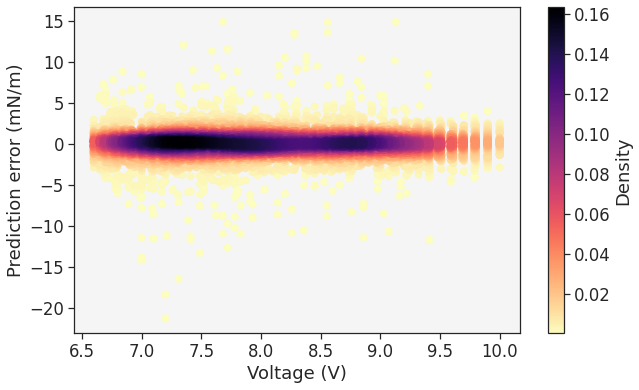

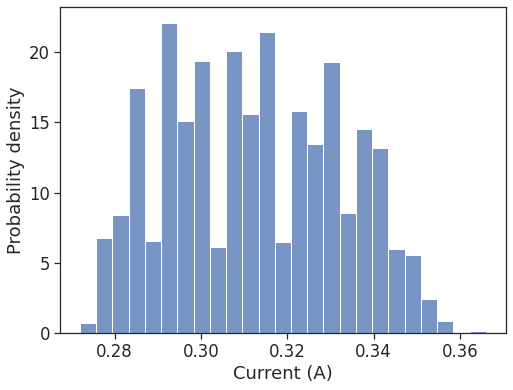

<Figure size 576x432 with 0 Axes>

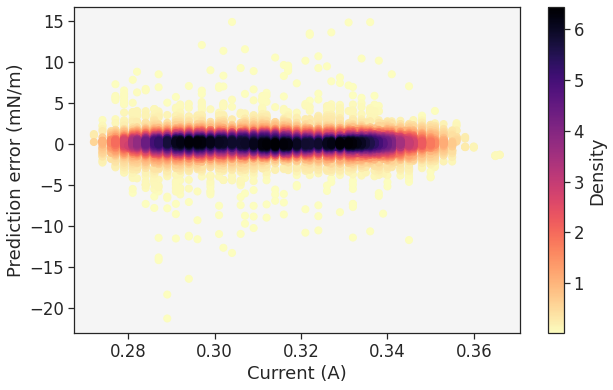

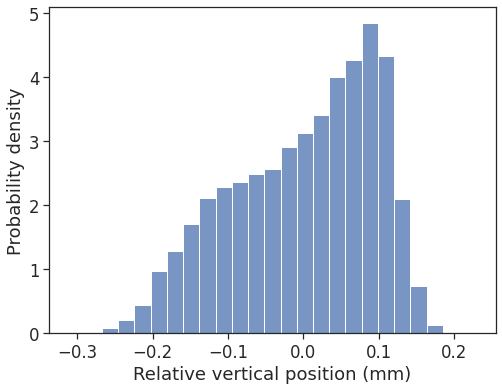

<Figure size 576x432 with 0 Axes>

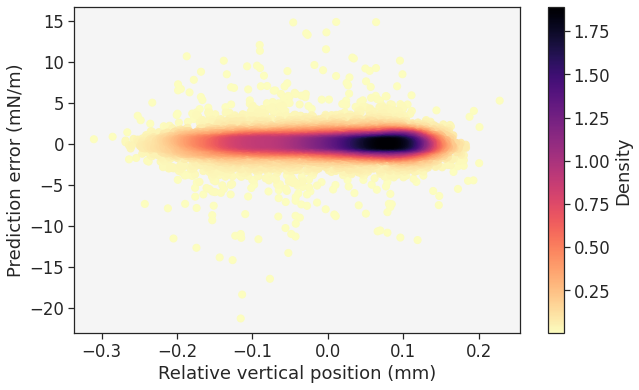

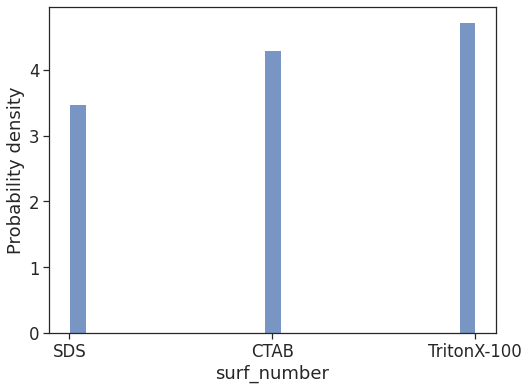

<Figure size 576x432 with 0 Axes>

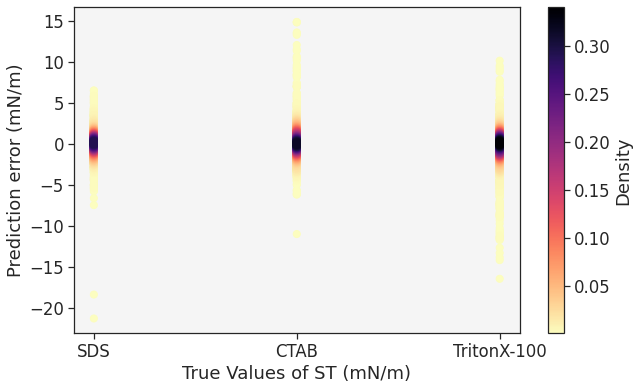

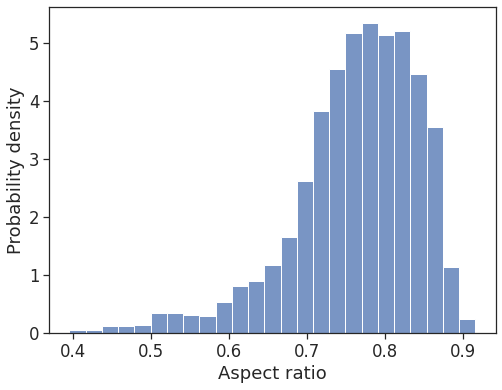

<Figure size 576x432 with 0 Axes>

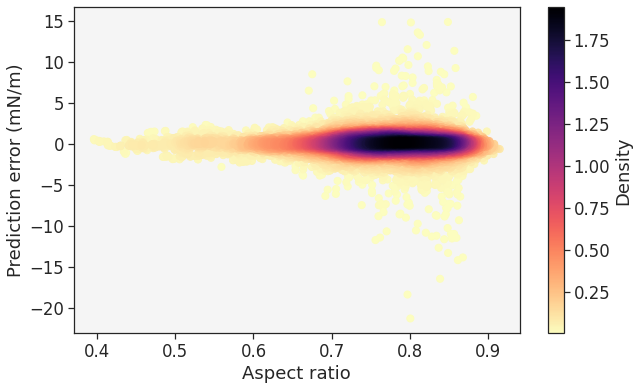

In [ ]:
savefig=False
sns.set_theme(style='ticks', font_scale=1.5)

#Volume distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density'),
sns.histplot(volume_test, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_volume_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_volume_png', dpi=300, format='png')


# Error Vs volume
plt.figure(figsize=(8,6))
density_scatter(volume_test, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Volume (μL)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_volume_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_volume_png', dpi=300, format='png')

################################################################################

#Voltage distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_data.volt, kde=False, bins=25, stat="density")
plt.xlabel('Voltage (V)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_voltage_png', dpi=300, format='png')


# Error Vs voltage
plt.figure(figsize=(8,6))
density_scatter(test_data.volt, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Voltage (V)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_voltage_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_voltage_png', dpi=300, format='png')

################################################################################

#Current distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_data.current, kde=False, bins=25, stat="density")
plt.xlabel('Current (A)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_current_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_current_png', dpi=300, format='png')


# Error Vs Current
plt.figure(figsize=(8,6))
density_scatter(test_data.current, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Current (A)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_current_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_current_png', dpi=300, format='png')

################################################################################

#Vertical position distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_data.centred_z, kde=False, bins=25, stat="density")
plt.xlabel('Relative vertical position (mm)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_vertical_pos_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_vertical_pos_png', dpi=300, format='png')


# Error Vs vertical position
plt.figure(figsize=(8,6))
density_scatter(test_data.centred_z, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Relative vertical position (mm)')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_vertical_pos_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_vertical_pos_png', dpi=300, format='png')

################################################################################

#Surfactant distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(surf_number_test, kde=False, bins=25, stat="density")
plt.xticks([0, 1, 2], ['SDS', 'CTAB', 'TritonX-100'])
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_surf_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_surf_png', dpi=300, format='png')


# Error Vs vertical position
plt.figure(figsize=(8,6))
density_scatter(surf_number_test, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xticks([0, 1, 2], ['SDS', 'CTAB', 'TritonX-100'])
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_surf_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_surf_png', dpi=300, format='png')

################################################################################

#Aspect ratio distribution of test dataset
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(1/Aspect_Ratio_test, kde=False, bins=25, stat="density")
plt.xlabel('Aspect ratio')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_distr_AR_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_distr_AR_png', dpi=300, format='png')


# Error Vs vertical position
plt.figure(figsize=(8,6))
density_scatter(1/Aspect_Ratio_test, error_test, lim1=None, lim2=None, eq_sq=False, figsize=(10,6))
plt.ylabel('Prediction error (mN/m)')
plt.xlabel('Aspect ratio')
# plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'test_data_error_Vs_AR_svg', dpi=300, format='svg')
  plt.savefig(path+'test_data_error_Vs_AR_png', dpi=300, format='png')



## Linear Regression Machine Learning Model

### Dummy regressor

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error

m = DummyRegressor()
cvr = cross_validate(m, normed_train_data, train_labels, scoring='neg_mean_squared_error')
m.fit(normed_train_data, train_labels)
predicted = m.predict(normed_test_data).flatten()

ST_real_test_dummy=rescaling(test_labels)
ST_pred_test_dummy=rescaling(predicted)

MAE = mean_absolute_error(ST_real_test_dummy, ST_pred_test_dummy)
MSE = mean_squared_error(ST_real_test_dummy, ST_pred_test_dummy)


print("Cross validation average negative mean squared error: %.3f" %(np.mean(cvr['test_score'])))
print('Mean absolute error on test data: %.3f' %MAE)
print('Mean squared error on test data: %.3f' %MSE)

Cross validation average negative mean squared error: -0.076
Mean absolute error on test data: 9.716
Mean squared error on test data: 129.657


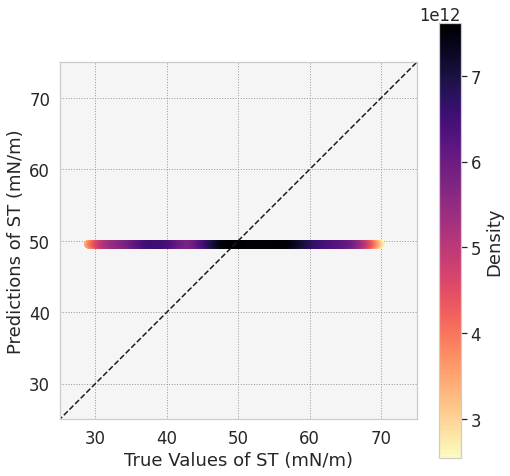

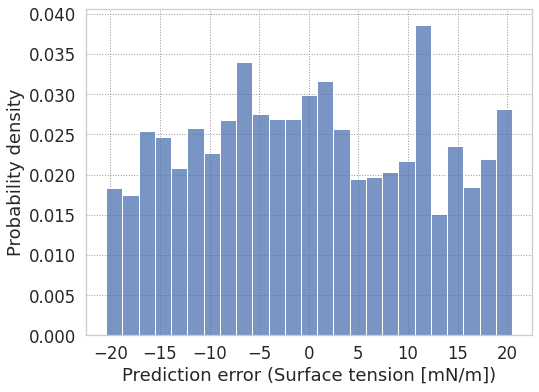

In [ ]:
def rescaling(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

path='/content/drive/My Drive/DropLev/for_draft/Experimental/Figures/'
savefig=True
colours='magma_r'

density_scatter(ST_real_test_dummy, ST_pred_test_dummy, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], '--k')
plt.xlim(25, 75)
plt.ylim(25, 75)
if savefig==True:
  plt.savefig(path+'DummyRegressor_error_plot_svg', dpi=300, format='svg')
  plt.savefig(path+'DummyRegressor_error_plot_png', dpi=300, format='png')


sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(ST_pred_test_dummy-ST_real_test_dummy, kde=False, bins=25, stat="density")
plt.xlabel('Prediction error (Surface tension [mN/m])')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'DummyRegressor_error_distr_svg', dpi=300, format='svg')
  plt.savefig(path+'DummyRegressor_error_distr_png', dpi=300, format='png')